In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import models, optimizers, layers, metrics
from PipelineStages import Loader, ImageProcessing, Labeler, DatasetBuilder, ModelTrainer

2023-07-07 13:55:52.036196: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def architecture_1(input_shape, n_filters, filter_size):
    network = models.Sequential()
    network.add(layers.Input(shape=(*input_shape, 1)))
    network.add(layers.Conv2D(n_filters[0], filter_size[0], strides=1, activation='relu'))
    network.add(layers.Conv2D(n_filters[1], filter_size[1], strides=1, activation='relu'))
    network.add(layers.Flatten())
    network.add(layers.Dense(2, activation='sigmoid'))
    return network

In [3]:
path = "/Users/jackmango/Desktop/QUIRP - Work/Princeton/Data/06:23:23/imaging exposure time = 30ms"

In [4]:
loader = Loader.Loader(100, 20, path, path + "/model1.h5")
stack, tot_loops, info = loader.run()

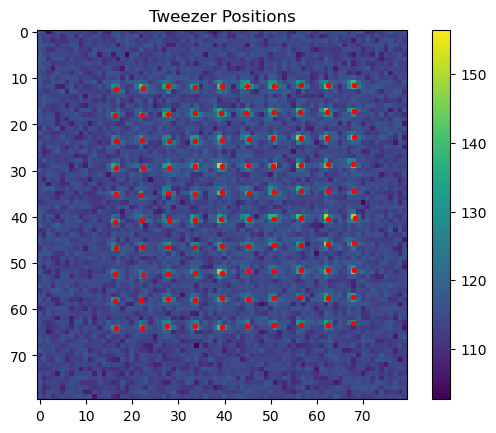

In [5]:
processor = ImageProcessing.ImageProcessor(stack, 100, tot_loops)
crops3x3, crops1x1, positions, info = processor.run()

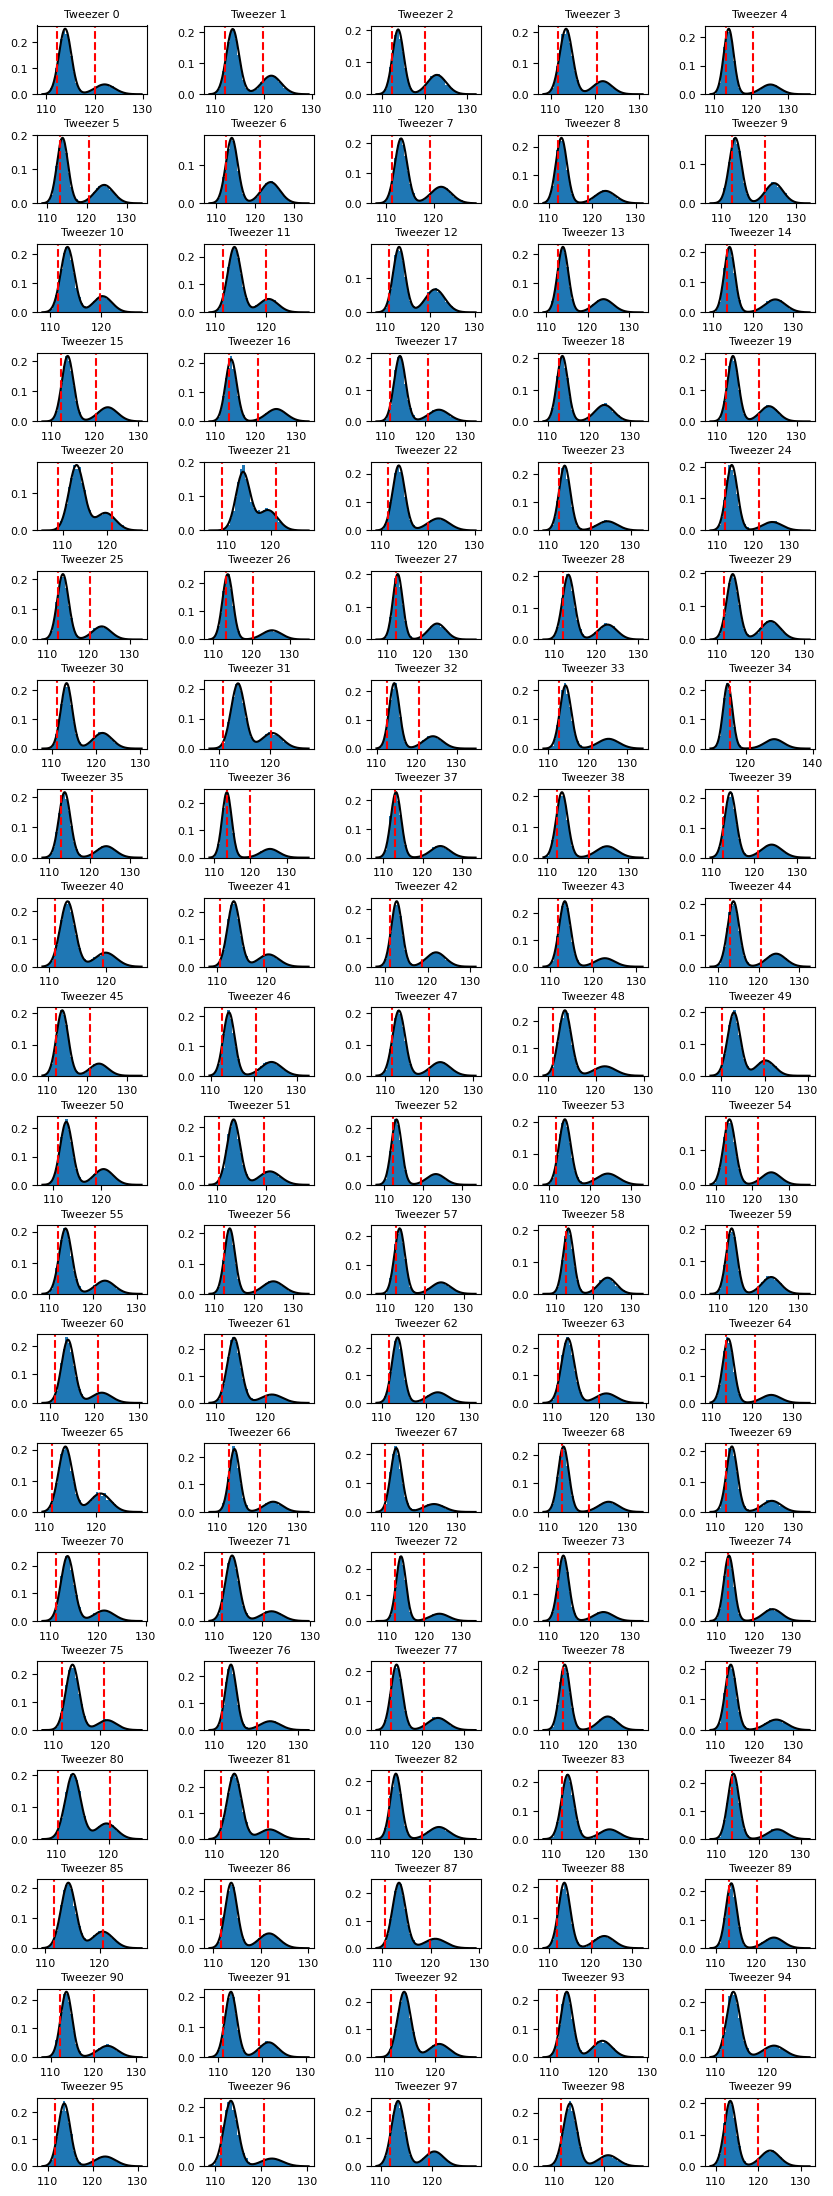

In [6]:
labeler = Labeler.Labeler(crops1x1, 100, tot_loops)
labels, info = labeler.run()

In [7]:
builder = DatasetBuilder.DatasetBuilder(crops3x3, labels)
training, testing, fidelity, info = builder.run()

In [8]:
model = architecture_1(crops3x3.shape[2:], [10, 10], [3, 3])
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy',
               metrics=[
                   'binary_accuracy',
                   metrics.TruePositives(),
                   metrics.TrueNegatives(),
                   metrics.FalsePositives(),
                   metrics.FalseNegatives()
                   ])

In [9]:
trainer = ModelTrainer.ModelTrainer(model, training, testing, fidelity, 100, tot_loops, epochs=8)
model, info = trainer.run()

Epoch 1/8
 5539/37899 [===>..........................] - ETA: 3:07 - loss: 0.1816 - binary_accuracy: 0.9615 - true_positives: 170495.0000 - true_negatives: 170339.0000 - false_positives: 6909.0000 - false_negatives: 6753.0000

In [ ]:
147.0000/122082.0000

0.0012041087138153046

In [ ]:
info = trainer.fidelity_analysis(trainer.n_tweezers, trainer.n_loops)

TypeError: fidelity_analysis() takes 1 positional argument but 3 were given

In [ ]:
info[0].mean()

0.004513297264295068

In [ ]:
print(fidelity.shape)

(1560000, 17, 17)
